In [1]:
import os
from dotenv import load_dotenv
while not os.getcwd().endswith("llm_agents"):
    os.chdir("..")
print(os.getcwd())

load_dotenv();
%load_ext autoreload
%autoreload 2

/Users/cristian/Personal/Projects/llm_agents


# Aperitech - LLM Agents: LangChain and LangGraph


## What is LangChain?

Langchain is a framework for developing and building applications powerd by large language models. As the name suggests, it allow to build a workflow as a chain of modular operations that can be executed in sequence or in parallel. The framework provides a common interface for:
- Prompting
- Information retrieval
- Interacting with language models, supporting also chatbot-like interactions
- Structuring the LLM output
- Persistence of interactions
- Tool management
- Orchestration

![alt text](https://python.langchain.com/svg/langchain_stack_112024_dark.svg)

   

## What is LangGraph?


LangGraph is a graph-based library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features. I can be used both as a standalone library or as a part of LangChain. among its features:
- `Cycles and Branching`: Implement loops and conditionals in your apps.
- `Persistence`: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- `Human-in-the-Loop`: Interrupt graph execution to approve or edit next action planned by the agent.
- `Streaming Support`: Stream outputs as they are produced by each node (including token streaming).
![alt](./images/langgraph_components.png)

### Why LangGraph?

LLMs are extremely powerful, particularly when connected to other systems such as a retriever or APIs.
Often a control flow of steps before and / or after an LLM is called a "chain." Chains are a popular paradigm for programming with LLMs and offer a high degree of reliability; the same set of steps runs with each chain invocation.

However, we often want LLM systems that can pick their own control flow! This is one definition of an `agent`: an agent is a system that uses an LLM to decide the control flow of an application. Unlike a chain, an agent gives an LLM some degree of control over the sequence of steps in the application. Rather than a fixed sequence of steps, an agent can decide which steps to take based on the output of the LLM. This includes:

- Routing between two potential paths
- Deciding which of many tools to call
- Is the generated answer sufficient or more work is needed?
  

### Agent Architectures

There are different types of agent architecrures to consider, giving the LLM different degrees of control over the application. On one extreme, a router allow an LLM to select a single step from a list of fixed options. On the other extreme, a fully autonomous agent gives the LLM full freedom to select any sequence of steps it want to solve a given problem. In between, there are many other shade of of gray.

![alt text](https://langchain-ai.github.io/langgraph/concepts/img/agent_types.png)

Desplite the chosen architecture, there are some common concepts that are shared by all agents:
- `Tool calling`: the agent can call tools not only to perform specific tasks but also to make decisions.
- `Action selection`: the agent can select the next action to take based on the output of the LLM.
- `Memory`: the agent can store information between steps or between different interactions with the user.
- `Planning`: the agent can plan a sequence of actions to achieve a goal.

In practice, there is often a trade-off between control and reliability. The more control the LLM has over the application, the less reliable it is. This can be due to the LLM making mistakes, non-determinism in the environment, or other factors. The goal of `LangGraph` is to help to bend the curve preserving higher reliability as we give the agent more control over the application.

### Graph Components

At its core, LangGraph models the agent workflows as graphs. You define the behavior of your agents using three key components:
1. `State`: a shared data structure that represents the current snapshot of the application.
2. `Nodes`: Python functions that encode the logic of your agents. They receive the current State as input (or a subset of the State), perform some computation or side-effect, and return an updated State. `They do the actual work`.
3. `Edges`: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions. They tell the agent `what to do next`.

![alt text](https://langchain-ai.github.io/langgraph/concepts/img/langgraph.png)
**How does it work?**

The underlying graph algorithm, uses the `message passing` paradigm to define a general program. When a Node completes its operation, it sends a message along one or more edges to other node(s). These receiving nodes then execute their functions, pass the resulting message to the next set of nodes, and so on.
A single iteration over the graph nodes is called a `super-step`. Nodes that runs in parallel are part of the same super-step, whereas nodes that run in sequence are part of different super-steps.
At the beginning of the execution, all nodes start in an `inactive` state. After receiving a message, a node becomes `active` then run its function and responds with updates. At the end of the super-step, nodes with no incoming messages vote to `halt` marking themselves as `inactive`.

To build a graph, you need first to define the `State`, then the `Nodes` and finally the `Edges`. You then create the graph with a `NetworkX` like style, and finally you compile and run the graph.

#### Workflow

The real power of the architecture comes from how LangGraph manages the State. The State consists of the schema of the graph as well as reducer functions specifying how to update the element of the State. The Schema can be defined either using `TypeDict` or a Pydantic `BaseModel`. 

**Multiple Schemas**

By default, the graph will have the same input and ouput schemas, however,there are cases where you might need more control over this, for example:
- Internal nodes can pass information that is not required in the graph's input/output
- We may want to use different input/output schemas for the graph. The output, might include only a subset of properties.

It is possible to have nodes write to private state channels inside the graph for internal node communication. We can simply define a private schema, PrivateState. See [this notebook](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) for more detail.

It is also possible to define explicit input and output schemas for a graph. In these cases, we define an "internal" schema that contains all keys relevant to graph operations. But, we also define input and output schemas that are sub-sets of the "internal" schema to constrain the input and output of the graph. See [this notebook](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/) for more detail.


**State Reducers**

Reducers are the key to understand how updates from nodes are applied to the State. Each property of the state has its own independent reducer function. If no reducer is defined, the default behavior is to replace the value of the property.

In [2]:
from typing import Annotated, Literal, Sequence

from langchain_core.messages import HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from IPython.display import Image, display

In [3]:
# Every time a node updates the state, the whole list of messages
# will be replaced with the new one.
class AgentStateNoReducerFunction(BaseModel):
    """State of an agent with no reducer function"""
    messages: Sequence[BaseMessage]

# The presence of a reducer function allows allow the agend to:
# - Append the new messages if they have different ids
# - Update the previous messages if they have the same id
# This allow a more efficient management of the state
class AgentState(BaseModel):
    """State of an agent with a reducer function"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Building a Simple Graph-based Agent
We will now build a simple graph-based agent that takes as input a user request and calls a tool to generate the answer.


#### 1. Initialize the model and tools
We use `ChatOpenAI` as our LLM. To make sure the model knows it has some available tools, we need to convert the `LangChain` tools into the `OpenAI` tool calling format with `.bind_tools()`.

[Here](https://python.langchain.com/docs/how_to/custom_tools/) you can find more information on how to create custom tools.

In [4]:
# Define the tools the agent can use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

# Tools are threated as a list of functions
tools = [search]

# Initialize a ChatOpenAI instance
model_name = 'gpt-4o'
temperature = 0.
model = ChatOpenAI(model=model_name, temperature=temperature).bind_tools(tools)

#### 2. Define the State
We use a simple Pydantic BaseModel that contains a sequence of BaseMessage objects, with the appropriate reducer function.

In [5]:
class AgentState(BaseModel):
    """State of an agent with a reducer function"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### 3. Define the Nodes of the graph
There are two main nodes we need:

- The `agent node`: responsible for deciding what (if any) actions to take.
- The `tools node` that invokes tools: if the agent decides to take an action, this node will then execute that action.

In [6]:
# Define the function that calls the model
def call_model(state: AgentState) -> AgentState:
    response = model.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# To define the tool node, we can rely on the ToolNode class
tool_node = ToolNode(tools)

#### 4. Define entry point and graph edges.
First, we need to set the entry point for graph execution - agent node.

Then we define one normal and one conditional edge. Conditional edge means that the destination depends on the contents of the graph's state (AgentState). In our case, the destination is not known until the agent (LLM) decides.

Conditional edge: after the agent is called, we should either:
- a. Run tools if the agent said to take an action, OR
- b. Finish (respond to the user) if the agent did not ask to run tools

Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next

In [7]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> Literal["tools", END]:
    messages = state.messages
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

#### 5. Compile and run the graph
To make the graph executable, we need to compile it. This will create a LangChain `Runnable` that can be invoked with the input data.

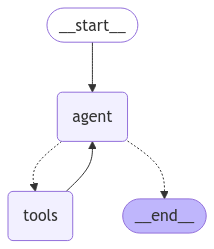

In [8]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
app = workflow.compile()

# To display the graph, we can use the `draw_mermaid_png` method
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

#### 6. Execute the graph
The workflow is the following:
1. LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, `"agent"`.
2. The `"agent"` node executes, invoking the chat model.
3. The chat model returns an `AIMessage`. LangGraph adds this to the state.
4. Graph cycles the following steps until there are no more `tool_calls` on `AIMessage`:
    - If `AIMessage` has `tool_calls`, `"tools"` node executes
    - The `"agent"` node executes again and returns `AIMessage`
Execution progresses to the special `END` value and outputs the final state. And as a result, we get a list of all our chat messages as output.

In [9]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in Milan?")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'The current weather in Milan is 90 degrees and sunny.'

### Agent with Structured Output
You might want your agent to return its output in a structured format. For example, if the output of the agent is used by some other downstream software, you may want the output to be in the same structured format every time the agent is invoked to ensure consistency. Basically, there are two different options to reach this goal:
1. Add a tool for structuring the output
2. Set an explicit post-processing step in the graph

Both of the options will use the same graph structure as shown in the diagram below, but will have different mechanisms under the hood.
![alt text](./images/structured_output_graph.png)

#### Option 1: Add a tool for structuring the output
The first way you can force your tool calling agent to have structured output is to bind the output you would like as an additional tool for the agent node to use. In contrast to the basic ReAct agent, the agent node in this case is not selecting between tools and END but rather selecting between the specific tools it calls. Then, among these tools there might be one or more tools responsable for structuring the output and deciding where to route the output (either ending the execution or moving to the next step).

![alt text](./images/structured_output_tool.png)

**Pros:**
The benefit to this format is that you only need one LLM, and can save money and latency because of this. The agent can be more flexible in its output, and can be more easily modified to have different output structures.

**Cons:**
The downside to this option is that it isn't guaranteed that the single LLM will call the correct tool when you want it to. We can help the LLM by setting `tool_choice` to `any` when we use `bind_tools` which forces the LLM to select at least one tool at every turn, but this is far from a fool proof strategy. In addition, another downside is that the agent might call multiple tools, so we need to check for this explicitly in our routing function (or if we are using OpenAI we an set `parallell_tool_calling=False` to ensure only one tool is called at a time).

An important note is the necessity of adding another response node to answer the user and provide the actual structured output. The idea is that, despite the agent can use a BaseModel as a tool, the actual answer will be a serialized object, whose parameters are are all strings. To convert this to an actual Object, we add this step that takes the arguments of that function call and return the object itself.

This is the reason why the two graph structure are the same.

### Option 2: Explicit post-process
The second way you can force your tool calling agent to have structured output is to use a second LLM (in this case `model_with_structured_output`) to parse the output of the first LLM.

![alt text](./images/structured_output_postprocess.png)
In this case, you will define a basic ReAct agent normally, but instead of having the agent node choose between the tools node and ending the conversation, the agent node will choose between the tools node and the respond node. The respond node will contain a second LLM that uses structured output, and once called will return directly to the user. You can think of this method as basic ReAct with one extra step before responding to the user.

**Pros:**
The benefit of this method is that it guarantees structured output (as long as `.with_structured_output` works as expected with the LLM).

**Cons:**
On the other hand, using this approach requires an additional LLM call before responding to the user, meaning additional cost and latency. 
Moreover, if the `agent` LLM (the one using tools) is not aware of the desired output schema, there is the risk that the agent LLM will fail to call the correct tools to generate the desired output. This can be mitigated with appropriate prompting and tool selection strategies, at the cost of increasing again the cost and latency of the system.

Let us explore an example. First we define how we want to structure our output, define our graph state, and also our tools and the models we are going to use. To use structured output, we will use the with_structured_output method from LangChain, which you can read more about [here](https://python.langchain.com/docs/how_to/structured_output/).

We are going to use a single tool in this example for finding the weather, and will return a structured weather response to the user.

In [10]:
from typing import Annotated, Literal, Sequence
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages


# Define the BaseModel that will be used as the structured output
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")

class BaseState(BaseModel):
    """Base state of the agent"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define the state of the agent
class AgentState(BaseState):
    """ State of the agent"""
    # Final structured response from the agent
    final_response: WeatherResponse | None = Field(
        description="The final response from the agent",
        default=None,
    )
    

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")


# Define the tools the agent can use
tools = [get_weather]

# Initialize a ChatOpenAI instance
model = ChatOpenAI(model="gpt-4o", temperature=0.0)

### Option 1: Add a tool for structuring the output
The graph definition is very similar to the one above, the only difference is we no longer call an LLM in the `response` node, and instead bind the `WeatherResponse` tool to our LLM that already contains the `get_weather` tool.


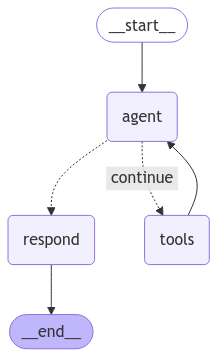

In [11]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# We can simply use the BaseModel we defined earlier as a tool for the structured output
tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_response_tool.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
# This perform the actual parsing of the response, taking the parameters to initialize
# the base model from the arguments of the last tool call
def respond(state: BaseState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state.messages[-1].tool_calls[0]["args"])
    # We return the final answer
    return {"final_response": response}


# Define the function that determins the conditional logic of the agent.
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [12]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})[
    "final_response"
]
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.82803)

### Option 2: Explicit post-process
Let's now dive into how we would use a second LLM to force structured output.


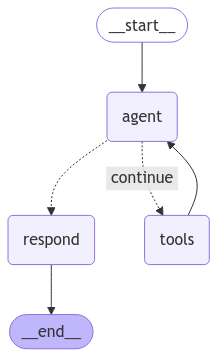

In [13]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage


# Define the tools the agent can use
tools = [get_weather]

# The difference with respect to previouse example is that here we do not
# need to force the agent to use the tools. Therefore, no need to use `tool_choice="any"`
model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(WeatherResponse)

# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_tools.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: BaseState):
    # Here, the respond node call another LLM, this time with structured output
    # in order to return the same format to the user every time.
    # We could have sent the entire chat history, sending just the `state.messages[-2]` saves tokens.
    # The reason we use `state.messages[-2]` is because:
    # state.messages[-1] is the response from the first model, wheras state.messages[-2] is the last ToolMessage
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state.messages[-2].content)]
    )
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [14]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})[
    "final_response"
]
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.82803)

## Memory and Persistence
LangGraph has a built-in persistence layer, implemented through `checkpointers`. When you compile graph with a checkpointer, the checkpointer saves a checkpoint of the graph state at every `super-step`. Those checkpoints are saved to a `thread`, which can be accessed after graph execution. Because threads allow access to graph's state after execution, several powerful capabilities including `human-in-the-loop`, `memory`, `time travel` are all possible. See this [how-to guide](https://langchain-ai.github.io/langgraph/how-tos/persistence/) for an end-to-end example on how to add and use checkpointers with your graph.

![alt text](https://langchain-ai.github.io/langgraph/concepts/img/persistence/checkpoints.jpg)

### Checkpoints
Checkpointing allow LangGraph agents to persist their state within and across multiple interactions. Basically, a checkpoint is a snapshot of the graph state saved at each super-step and is represented by `StateSnapshot` object with the following key properties:
- `config`: configuration associated with the checkpoint
- `metadata`: metadata associated with the checkpoint
- `values`: values of the state channels at this point in time
- `next`: A tuple of `PregetTask` objects, containing information about the next task to be executed. If the step was   previously attempted, it include error information. Moreover, if a graph was interrupted dynamically from a node, tasks will contain additional information associated with the interruption.

#### Threads
A set of checkpoints can be associated with a thread, by means of the `config` parameter.

In [26]:
from langgraph.checkpoint.memory import MemorySaver
# Configure the graph structure as before
# Then just before the comple, we define our checkpointer along with the configuration parameter
checkpointer = MemorySaver()

# Compile the graph with the checkpointer
graph = workflow.compile(checkpointer=checkpointer)

# Define the configuration parameter
config = {"configurable": {"thread_id": "1"}}

# Invoke the graph with the configuration parameter
graph.invoke(
    input={"messages": [("human", "what's the weather in SF?")]},
    config=config
)


--- Dynamic Breakpoint Interruption ---


{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='dd338175-c8de-4e42-af07-3b31a9b41798'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fnPEbg1a6EPyiF3sBrn8yit9', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 115, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6125b4a1-ead0-48b2-8be2-e60a27a8a591-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_fnPEbg1a6EPyiF3sBrn8yit9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 115, 'o

Unexpected error occurred. Please check your request and contact support: https://langfuse.com/support.


**Get the history**

You can get the full history of the graph execution for a given thread by calling `graph.get_state_history(config)`. This will return a list of `StateSnapshot` objects associated with the thread ID provided in the config ordered from the most recent checkpoint to the oldest.


In [16]:
# To access the list of checkpoints in reverse order
history = list(graph.get_state_history(config))
print(history)


[StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='59fac207-027f-4f56-8e49-dc96bc4aa47b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ad02028-e88a-459a-89fa-838487770aa9-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'type': 'tool_call'}], usage_metadata={'inpu

**Get a specific state**

You can also access directly the last state of the graph for a give thread using or a specific checkpoint.

In [17]:
# You can get the last state in memory
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state(config))

[{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='59fac207-027f-4f56-8e49-dc96bc4aa47b'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ad02028-e88a-459a-89fa-838487770aa9-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'ou

In [18]:
# Or, you can access the state of a specific checkpoint. For instance, considering the first checkpoint in time
first_checkpoint_config = {"configurable": {"thread_id": "1", "checkpoint_id": history[-2].config['configurable']['checkpoint_id']}}
list(graph.get_state(first_checkpoint_config))

[{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='59fac207-027f-4f56-8e49-dc96bc4aa47b')]},
 ('agent',),
 {'configurable': {'thread_id': '1',
   'checkpoint_id': '1efbbb37-ed04-6d3a-8000-8990f7ab43e5'}},
 {'source': 'loop',
  'writes': None,
  'thread_id': '1',
  'step': 0,
  'parents': {}},
 '2024-12-16T13:41:47.289517+00:00',
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efbbb37-ed00-6f0a-bfff-4e71f53d4c34'}},
 (PregelTask(id='3af89e53-9244-3410-4159-523ec4a9106e', name='agent', path=('__pregel_pull', 'agent'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_token

### Replay 
It's also possible to play-back a prior graph execution. By `invoking` a graph with a `thread_id` and a `checkpoint_id`, we can re-play the graph from that specific checkpoint.

**Note**:

 LangGraph knows whether a particular checkpoint has been executed previously. If it has, LangGraph simply re-plays that particular step in the graph and does not re-execute the step. See this how to guide on [time-travel](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) to learn more about replaying.

In [19]:
last_checkpoint_config = {"configurable": {"thread_id": "1", "checkpoint_id": history[0].config['configurable']['checkpoint_id']}}

# The input is explicitly set to None in order to re-play the specific checkpoint
graph.invoke(None, config=last_checkpoint_config)

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='59fac207-027f-4f56-8e49-dc96bc4aa47b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ad02028-e88a-459a-89fa-838487770aa9-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_TfepCbZMWo70MIrEuEBLX7z5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'outp

### Update the state
Beside re-playing the graph, it is also possible to edit the graph state at a specific checkpoint. This is useful to correct errors or to include additional information provided by the user (`human-in-the-loop`). This can be done with the
`graph.update_state` method that takes three parameters:
- `config`: the config should contain the `thread_id` specifying which thread to update. If only the thread_id is passed, the current state (equivalent to the last checkpoint) is forked. Optionally, if also the `checkpoint_id` field is provided, then the execution is forked from that specific checkpoint.
- `values`: the values that will be used to update the state, according to the schema of the graph. The updated is performed as any other state update (like the values would have been returned by a node), meaning that the reducers are applied to the values. Let's see an example
    ``` python
    from typing import Annotated
    from typing_extensions import TypedDict
    from operator import add

    class State(TypedDict):
        foo: int
        bar: Annotated[list[str], add]
    ```
    Assuming that the current state is:
    ``` python 
    {"foo": 1, "bar": ["a"]}
    ```
    If you update the state as below:
    ``` python
    graph.update_state(config, {"foo": 2, "bar": ["b"]})
    ```
    The new state will be:
    ``` python
    {"foo": 3, "bar": ["a", "b"]}
    ```
    The `foo` key (channel) is completely changed (because there is no reducer specified for that channel, so update_state overwrites it). However, there is a reducer specified for the `bar` key, and so it appends "b" to the state of bar.
- `as_node`: optionally, you can provide the `as_node` parameter to apply the update as it would have come from a specific node. If not provided, it will be set to the last node that updated the state, if not ambiguous. This is useful to control which node executes next. See this how to guide on [time-travel](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) to learn more about forking state.

### Breakpoints
Breakpoints are a way to stop the execution of the graph at a specific node. This is useful for debugging, or for human-in-the-loop workflows. When a breakpoint is reached, the graph execution is paused and the state is saved to the checkpoint. The user can then inspect the state, make changes, and resume the execution.

You **MUST** use a checkpointer when using breakpoints. This is because your graph needs to be able to resume execution.


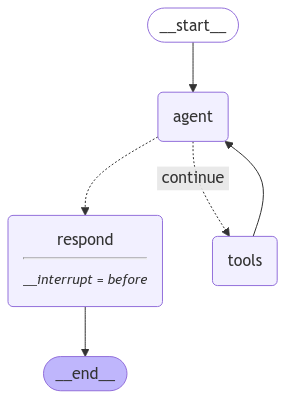

In [20]:
# We can simply use the BaseModel we defined earlier as a tool for the structured output
tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_response_tool.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
# This perform the actual parsing of the response, taking the parameters to initialize
# the base model from the arguments of the last tool call
def respond(state: BaseState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state.messages[-1].tool_calls[0]["args"])
    # We return the final answer
    return {"final_response": response}


# Define the function that determins the conditional logic of the agent.
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)


# Compile the graph with the checkpointer
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['respond'])
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

# Define the configuration parameter


In [21]:
config = {"configurable": {"thread_id": "1"}}

# Invoke the graph with the configuration parameter
inputs={"messages": [("human", "what's the weather in sf?")]}

# Stream the graph execution
for event in graph.stream(inputs, config, stream_mode="values"):
    print(event)

# Perform some action that requires human in the loop
print("--- Static Breakpoint ---")
user_approval = input("Do you want to parse the output? (yes/no): ")

# Continue the graph execution from the current checkpoint if the user approves
if user_approval.lower() == "yes":
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()
else:
    print("Operation cancelled by user.")

{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='91f30800-33c7-48ea-90d2-d05e23b30385')]}
{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='91f30800-33c7-48ea-90d2-d05e23b30385'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fN6HUDOcgjQOSGr2bd7J704Q', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 115, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-54fc5bea-4093-4b8d-b747-269664516c6b-0', tool_calls

### Dynamic Breakpoints
Alternatively, the developer can define some condition that must be met for a breakpoint to be triggered. To this end, we can raise a `NodeInterrupt` exception when a particular condition is met. 




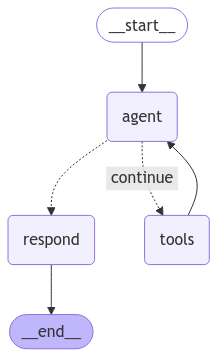

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_7YE7VXa3vPpdrZIV55xD4UJF)
 Call ID: call_7YE7VXa3vPpdrZIV55xD4UJF
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction
================================== Ai Message ==================================
Tool Calls:
  WeatherResponse (call_i5IdJYXa1DFE4qQXxrZRTaky)
 Call ID: call_i5IdJYXa1DFE4qQXxrZRTaky
  Args:
    temperature: 75
    wind_directon: SE
    wind_speed: 4.82803
--- Dynamic Breakpoint Interruption ---

 ---------------------------------- 

================================== Ai Message ==================================
Tool Calls:
  WeatherResponse (call_i5IdJYXa1DFE4qQXxrZRTaky)
 Call ID: call_i5IdJYXa1DFE4qQXxrZ

In [22]:
from langgraph.errors import NodeInterrupt
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# We can simply use the BaseModel we defined earlier as a tool for the structured output
tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_response_tool.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
# This perform the actual parsing of the response, taking the parameters to initialize
# the base model from the arguments of the last tool call
def respond(state: BaseState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state.messages[-1].tool_calls[0]["args"])
    if response.temperature == 75:
        print("--- Dynamic Breakpoint Interruption ---")
        raise NodeInterrupt("The temperature is 75 degrees, do you want to proceed? (yes/no)")
    # We return the final answer
    return {"final_response": response}


# Define the function that determins the conditional logic of the agent.
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)


# Compile the graph with the checkpointer
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

# Define the configuration parameter
config = {"configurable": {"thread_id": "1"}}

# Invoke the graph with the configuration parameter
inputs={"messages": [("human", "what's the weather in sf?")]}

for event in graph.stream(inputs, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

print("\n ---------------------------------- \n")
# Continue the graph execution from the current checkpoint if the user approves
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Save the snapshot checkpoint
history = list(graph.get_state_history(config))
rollback_config = history[0].config

What we can see now is that the dynamic interruption is triggered again, this is because the node will be runned again from the same state, resulting in the same condition to be met. To avoid this we have basically two options:
- `State update`: alternatively, we can update the state in order to avoid the condition to be met again.

In [23]:
message = graph.get_state(rollback_config).values['messages'][-1]
response_param = message.tool_calls[0]["args"]
response_param['temperature'] = 76

graph.update_state(config=rollback_config, values={"messages": [message]})
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  WeatherResponse (call_i5IdJYXa1DFE4qQXxrZRTaky)
 Call ID: call_i5IdJYXa1DFE4qQXxrZRTaky
  Args:
    temperature: 76
    wind_directon: SE
    wind_speed: 4.82803
================================== Ai Message ==================================
Tool Calls:
  WeatherResponse (call_i5IdJYXa1DFE4qQXxrZRTaky)
 Call ID: call_i5IdJYXa1DFE4qQXxrZRTaky
  Args:
    temperature: 76
    wind_directon: SE
    wind_speed: 4.82803


- `Skip the node`: we can skip the node that perfor the check by adding the `as_node` parameter to the `update_state` method.

In [24]:
graph.update_state(config=rollback_config, values=None, as_node="respond")
for event in graph.stream(None, rollback_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  WeatherResponse (call_i5IdJYXa1DFE4qQXxrZRTaky)
 Call ID: call_i5IdJYXa1DFE4qQXxrZRTaky
  Args:
    temperature: 75
    wind_directon: SE
    wind_speed: 4.82803
--- Dynamic Breakpoint Interruption ---


## Human-in-the-Loop
A human-in-the-loop workflow integrates human input into automated processes, allowing for decisions, validation, or corrections at key stages. This is especially useful in LLM-based applications, where the underlying model may generate occasional inaccuracies. In low-error-tolerance scenarios like compliance, decision-making, or content generation, human involvement ensures reliability by enabling review, correction, or override of model outputs.

Typical usecases include:
- **Reviewing tool calls**: humans can review, edit, or approve tool calls requested by the LLM before tool execution.
- **Validating LLM outputs**: humans can review, edit, or approve the content generated by the LLM 
- **Providing context**: enables the LLM to explicitly request human input for clarification or additiona details to support multi-turn conversations.

All of these interaction patterns are enabled by the persistence layer, which allow to stop the execution and update the state of the graph at each step.


### interrupt
The `interrupt` function enables human-in-the-loop workflows by pausing the graph at a given node, presenting information to a human, and resuming the graph with their input. This function is useful for tasks like approvals, edits, or collectiong the input. In Conjunction with the `Command` object, it allow to resume the graph with a value provided by the user.

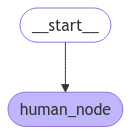

{'__interrupt__': (Interrupt(value={'text_to_revise': 'Original text'}, resumable=True, ns=['human_node:f1e8ab77-c902-8380-0938-6b13bf12d788'], when='during'),)}
{'human_node': {'some_text': 'This is the correct text'}}


In [38]:
from typing import TypedDict
import uuid

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from pydantic import BaseModel

class State(BaseModel):
   """The graph state."""
   some_text: str

def human_node(state: State):
   value = interrupt(
      # Any JSON serializable value to surface to the human.
      # For example, a question or a piece of text or a set of keys in the state
      {
         "text_to_revise": state.some_text
      }
   )
   return {
      # Update the state with the human's input
      "some_text": value
   }


# Build the graph
graph_builder = StateGraph(State)
# Add the human-node to the graph
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

# A checkpointer is required for `interrupt` to work.
checkpointer = MemorySaver()
graph = graph_builder.compile(
   checkpointer=checkpointer
)

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

# Pass a thread ID to the graph to run it.
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}
original_text = "Original text"

# Using stream() to directly surface the `__interrupt__` information.
for chunk in graph.stream({"some_text": original_text}, config=thread_config):
   print(chunk)

user_input = input(f"The current text is {original_text}, do you confirm? (yes to continue/no to edit):")
if user_input.lower() == "no":
   user_input = input("Please enter the correct text: ")
else:
   user_input = original_text
# Resume using Command
for chunk in graph.stream(Command(resume=user_input), config=thread_config):
   print(chunk)

#### Design Patterns
There are several design patterns that can be used to implement human-in-the-loop workflows. The most common patterns are:
- **Approve or Reject**: the idea is to pause the graph before a critical step, and ask the user to approve or reject the action. This pattern often requires `routing` the graph based on the user's response.
  
  ![alt text](https://langchain-ai.github.io/langgraph/concepts/img/human_in_the_loop/approve-or-reject.png)
  ```python
      from typing import Literal
      from langgraph.types import interrupt, Command

      def human_approval(state: State) -> Command[Literal["some_node", "another_node"]]:
          is_approved = interrupt(
              {
                  "question": "Is this correct?",
                  # Surface the output that should be
                  # reviewed and approved by the human.
                  "llm_output": state.llm_output
              }
          )

          if is_approved:
              return Command(goto="some_node")
          else:
              return Command(goto="another_node")

      # Add the node to the graph in an appropriate location
      # and connect it to the relevant nodes.
      graph_builder.add_node("human_approval", human_approval)
      graph = graph_builder.compile(checkpointer=checkpointer)

      # After running the graph and hitting the interrupt, the graph will pause.
      # Resume it with either an approval or rejection.
      thread_config = {"configurable": {"thread_id": "some_id"}}
      graph.invoke(Command(resume=True), config=thread_config)
  ```
- **Review and Edit State**: a human can review and edit the state of the graph. This is useful for correcting mistakes or updating the state with additional information. A more detailed example is available [here](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#interacting-with-the-agent)

  ![alt text](https://langchain-ai.github.io/langgraph/concepts/img/human_in_the_loop/edit-graph-state-simple.png)
  ```python
      from langgraph.types import interrupt
      def human_editing(state: State):
          ...
          result = interrupt(
              # Interrupt information to surface to the client.
              # Can be any JSON serializable value.
              {
                  "task": "Review the output from the LLM and make any necessary edits.",
                  "llm_generated_summary": state["llm_generated_summary"]
              }
          )

          # Update the state with the edited text
          return {
              "llm_generated_summary": result["edited_text"] 
          }

      # Add the node to the graph in an appropriate location
      # and connect it to the relevant nodes.
      graph_builder.add_node("human_editing", human_editing)
      graph = graph_builder.compile(checkpointer=checkpointer)

      ...

      # After running the graph and hitting the interrupt, the graph will pause.
      # Resume it with the edited text.
      thread_config = {"configurable": {"thread_id": "some_id"}}
      graph.invoke(
          Command(resume={"edited_text": "The edited text"}), 
          config=thread_config
      )
  ```
- **Review Tool Calls**: again, the user can review and edit the output of the LLM before proceeding. A more detailed example is available [here](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/review-tool-calls/)
  
  ![alt text](https://langchain-ai.github.io/langgraph/concepts/img/human_in_the_loop/tool-call-review.png)
  ```python
    def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
      # This is the value we'll be providing via Command(resume=<human_review>)
      human_review = interrupt(
          {
              "question": "Is this correct?",
              # Surface tool calls for review
              "tool_call": tool_call
          }
      )

      review_action, review_data = human_review

      # Approve the tool call and continue
      if review_action == "continue":
          return Command(goto="run_tool")

      # Modify the tool call manually and then continue
      elif review_action == "update":
          ...
          updated_msg = get_updated_msg(review_data)
          # Remember that to modify an existing message you will need
          # to pass the message with a matching ID.
          return Command(goto="run_tool", update={"messages": [updated_message]})

      # Give natural language feedback, and then pass that back to the agent
      elif review_action == "feedback":
          ...
          feedback_msg = get_feedback_msg(review_data)
          return Command(goto="call_llm", update={"messages": [feedback_msg]})
  ```

- **Multi-turn conversation**: a multi-turn conversation involves multiple back-and-forth interactions between an agent and a human, which can allow the agent to gather additional information from the human in a conversational manner. 
  
  ![alt text](https://langchain-ai.github.io/langgraph/concepts/img/human_in_the_loop/multi-turn-conversation.png)
  This design pattern is useful in an LLM application consisting of multiple agents. One or more agents may need to carry out multi-turn conversations with a human, where the human provides input or feedback at different stages of the conversation. For simplicity, the agent implementation below is illustrated as a single node, but in reality it may be part of a larger graph consisting of multiple nodes and include a conditional edge.
  Under this setting it is possible to have both:
    - `Single Human Node per Agent`: each agent has its own human node for collecting user input. This can be achieved by either naming the human nodes with unique names (e.g., "human for agent 1", "human for agent 2") or by using subgraphs where a subgraph contains a human node and an agent node.
        ```python
            from langgraph.types import interrupt

            def human_input(state: State):
                human_message = interrupt("human_input")
                return {
                    "messages": [
                        {
                            "role": "human",
                            "content": human_message
                        }
                    ]
                }

            def agent(state: State):
                # Agent logic
                ...

            graph_builder.add_node("human_input", human_input)
            graph_builder.add_edge("human_input", "agent")
            graph = graph_builder.compile(checkpointer=checkpointer)

            # After running the graph and hitting the interrupt, the graph will pause.
            # Resume it with the human's input.
            graph.invoke(
                Command(resume="hello!"),
                config=thread_config
            )
        ```
    - `Shared Human Node for Multiple Agents`: a single human node is used to collect user input for multiple agents. The active agent is determined from the state (the idea is to set the active agent before interrupting), so after human input is collected, the graph can route to the correct agent. 
        ```python
            from langgraph.types import interrupt
            def human_node(state: MessagesState) -> Command[Literal["agent_1", "agent_2", ...]]:
                """A node for collecting user input."""
                user_input = interrupt(value="Ready for user input.")

                # Determine the **active agent** from the state, so 
                # we can route to the correct agent after collecting input.
                # For example, add a field to the state or use the last active agent.
                # or fill in `name` attribute of AI messages generated by the agents.
                active_agent = ... 

                return Command(
                    update={
                        "messages": [{
                            "role": "human",
                            "content": user_input,
                        }]
                    },
                    goto=active_agent,
                )
        ```


#### Validate the Human input
If you need to validate the input provided by the human within the graph itself (rather than on the client side), you can achieve this by using multiple interrupt calls within a single node.

```python
    from langgraph.types import interrupt

    def human_node(state: State):
        """Human node with validation."""
        question = "What is your age?"

        while True:
            answer = interrupt(question)

            # Validate answer, if the answer isn't valid ask for input again.
            if not isinstance(answer, int) or answer < 0:
                question = f"'{answer} is not a valid age. What is your age?"
                answer = None
                continue
            else:
                # If the answer is valid, we can proceed.
                break

        print(f"The human in the loop is {answer} years old.")
        return {
            "age": answer
        }
```

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Found edge ending at unknown node `some_node`

## How to debug?
`LangSmith` is a platform for building production-grade LLM applications. It allows you to monitor and evaluate your application, visualizing the message exchange with the LLMs. If interested, you can find more information [here](https://python.langchain.com/docs/how_to/debugging/).

The main drawback of using LangSmith is that it is not free. It has a free-tier, but for more advanced features you will need to pay. An open-source alternative is [LangFuse](https://github.com/langfuse/langfuse). It presents a similar interface providing a completely free self-hosted solution and a cloud-based solution with a larger free-tier, compared to LangSmith.

In [31]:
from langfuse.callback import CallbackHandler

# Define the function that calls the model
def call_model(state: AgentState) -> AgentState:
    response = model.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# To define the tool node, we can rely on the ToolNode class
tool_node = ToolNode(tools)


langfuse_handler = CallbackHandler()
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
config['callbacks'] = [langfuse_handler]

answer = graph.invoke(
    input={"messages": [("human", "what's the weather in SF?")]},
    config=config,
)[
    "final_response"
]
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='d8b25352-3e1b-4ef4-a66e-42c408baca0b'),
  AIMessage(content="I'm unable to provide real-time weather updates. For the current weather in San Francisco, I recommend checking a reliable weather website or app like Weather.com, the Weather Channel, or a local news station's website.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 14, 'total_tokens': 56, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'stop', 'logprobs': None}, id='run-a0aacf5c-bd21-45ce-bb54-d9c8241ef9cb-0', usage_metadata={'input_tokens': 14, 'output_tokens': 42, 'total_tokens': 56, 'input_token_deta

Unexpected error occurred. Please check your request and contact support: https://langfuse.com/support.
Unexpected error occurred. Please check your request and contact support: https://langfuse.com/support.
